In [46]:
import pickle
from random import randint
import string
import re
import math
import pandas as pd
import numpy as np
from numpy import array
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
%matplotlib inline
import seaborn as sns
import spacy

import nltk
from nltk import FreqDist
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
# nltk.download('stopwords')
# nltk.download('punkt')
# nltk.download('wordnet')


from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import TruncatedSVD
from sklearn.decomposition import NMF
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

from gensim import corpora, models, similarities, matutils

from wordcloud import WordCloud

# # libraries for visualization
# import pyLDAvis
# import pyLDAvis.gensim
# import matplotlib.pyplot as plt
# import seaborn as sns
# %matplotlib inline

# import tensorflow.compat.v1 as tf
# tf.disable_v2_behavior()

In [47]:
# load doc into memory
def load_doc(filename):
    file = open(filename,'r')
    text = file.read()
    file.close()
    return text

In [48]:
# save tokens to file, one dialog per line
def save_doc(lines, filename):
    data = '\n'.join(lines)
    file = open(filename, 'w')
    file.write(data)
    file.close()

In [49]:
def seperate_verses(corpus):  
    split_corpus = corpus.split('\\r\\n')
    return split_corpus

In [50]:
# turn a doc into clean tokens
def clean_doc(doc):
    # split into tokens by white space
    tokens = doc.split()
    
    # prepare regex for char filtering
    re_punc = re.compile('[%s]'% re.escape(string.punctuation))
    
    # remove punctuation from each word
    tokens = [re_punc.sub('', w) for w in tokens]
    
    # remove remaining tokens that are not alphabetic
    tokens = [word for word in tokens 
              if word.isalpha()]
    
    # make lower case
    tokens = [word.lower() for word in tokens]
    
    return tokens

In [51]:
def clean_corpus(corpus):
    corpus = seperate_verses(corpus)
    cleaned_corpus = []
    for i in range(len(corpus)):
        cleaned_doc = clean_doc(corpus[i])
        cleaned_corpus.append(cleaned_doc)
        
    return cleaned_corpus

In [52]:
def corpus_docs_list_to_str(corpus):
    new_corpus = []
    for i in range(len(corpus)):
        new_doc = ' '.join(corpus[i])
        new_corpus.append(new_doc)
        
    return new_corpus

In [53]:
def corpus_to_tokens_to_sequences(corpus,sequence_length=50):
    tokens = ' '.join(corpus)
    tokens = tokens.split()
    # organize into sequences of tokens
    length = sequence_length + 1
    sequences = []
    for i in range(length, len(tokens)):
        # select sequence of tokens
        seq = tokens[i-length:i]
        # convert into a line
        line = ' '.join(seq)
        # store
        sequences.append(line)
    print('Total Sequences: %d' % len(sequences))
    return sequences

## Data Cleaning

In [54]:
# Opening file as bytes due to non-ascii character
with open('quran_english.txt', 'rb') as f:
    quran = f.read()
quran = str(quran)

In [55]:
# Clean entire quran
clean_quran = clean_corpus(quran)

In [11]:
# Export clean quran
# out_filename = 'clean_quran.txt'
# save_doc(clean_quran, out_filename)

In [56]:
# Converting verses from lists to strings
clean_quran = corpus_docs_list_to_str(clean_quran)

In [57]:
# saving quranament sequences to txt file
quran_sequences = corpus_to_tokens_to_sequences(clean_quran)
# out_filename = 'quran_sequences.txt'
# save_doc(quran_sequences, out_filename)

Total Sequences: 156893


## NLP Preprocessing

In [186]:
def tokenize_corpus(corpus):
    tokenized_corpus = []
    for verse in corpus:
        tokenized_corpus.append(word_tokenize(verse))
    return tokenized_corpus        

In [282]:
extra_stopwords = ['allah','ye','lord','thou','said','shall',
                   'say','thee','thy','people','u']

In [283]:
def remove_stopwords(corpus):
    stop_words = stopwords.words('english')
    stop_words.extend(extra_stopwords)
    new_corpus = []
    for verse in corpus:
        new_verse = []
        for word in verse:
            if word not in stop_words:
                new_verse.append(word)
        new_corpus.append(new_verse)
    return new_corpus

In [284]:
def stemming_corpus(corpus):
    stemmed_corpus = []
    stemmer= PorterStemmer()
    for verse in corpus:
        stemmed_corpus.append([stemmer.stem(word) for word in verse])
    return stemmed_corpus

In [190]:
def lemmatize_corpus(corpus):
    lemmatized_corpus = []
    lemmatizer=WordNetLemmatizer()
    for verse in corpus:
        lemmatized_corpus.append([lemmatizer.lemmatize(word) for word in verse])
    return lemmatized_corpus

In [227]:
### Preprocessing Quran

# Tokenizing 
tokenized_quran = tokenize_corpus(clean_quran)

# Removing Stop Words 
tokenized_nostop_quran = remove_stopwords(tokenized_quran)

#Stemming and Lemmatizing
quran_stemmed = stemming_corpus(tokenized_nostop_quran)
quran_lemmatized = lemmatize_corpus(tokenized_nostop_quran)

## Exploratory Data Analysis

In [228]:
def join_tokenized_words(corpus):
    
    all_words = []
    for verse in corpus:
        joined_verse = ' '.join(verse)
        all_words.append(joined_verse)
    
    return all_words

In [229]:
def join_tokenized_verses(corpus):
    
    all_words = join_tokenized_words(corpus)
    all_words = ' '.join(all_words)
    all_words = all_words.split()
    
    return all_words

In [166]:
# function to plot most frequent terms
def freq_words(corpus, terms=30):
    
    fdist = FreqDist(corpus)
    words_df = pd.DataFrame({'word':list(fdist.keys()), 'count':list(fdist.values())})

    # selecting most frequent words
    d = words_df.nlargest(columns="count", n = terms) 
    plt.figure(figsize=(20,5))
    ax = sns.barplot(data=d, x= "word", y = "count")
    ax.set(ylabel = 'Count')
    plt.show()
    return

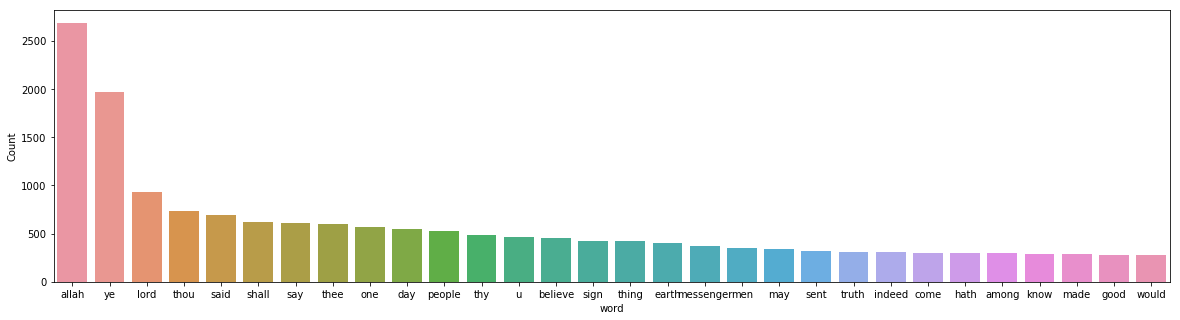

In [171]:
freq_words(join_tokenized_verses(quran_lemmatized))

In [67]:
def show_wordcloud(data, title = None):
    wordcloud = WordCloud(
        colormap='seismic',
        background_color='white',
        max_words=200,
        max_font_size=40, 
        scale=3,
        random_state=1 
    ).generate(str(data))

    fig = plt.figure(1, figsize=(12, 12),dpi=300)
    plt.axis('off')
    if title: 
        fig.suptitle(title, fontsize=20)
        fig.subplots_adjust(top=2.3)

    plt.imshow(wordcloud)
    plt.show()

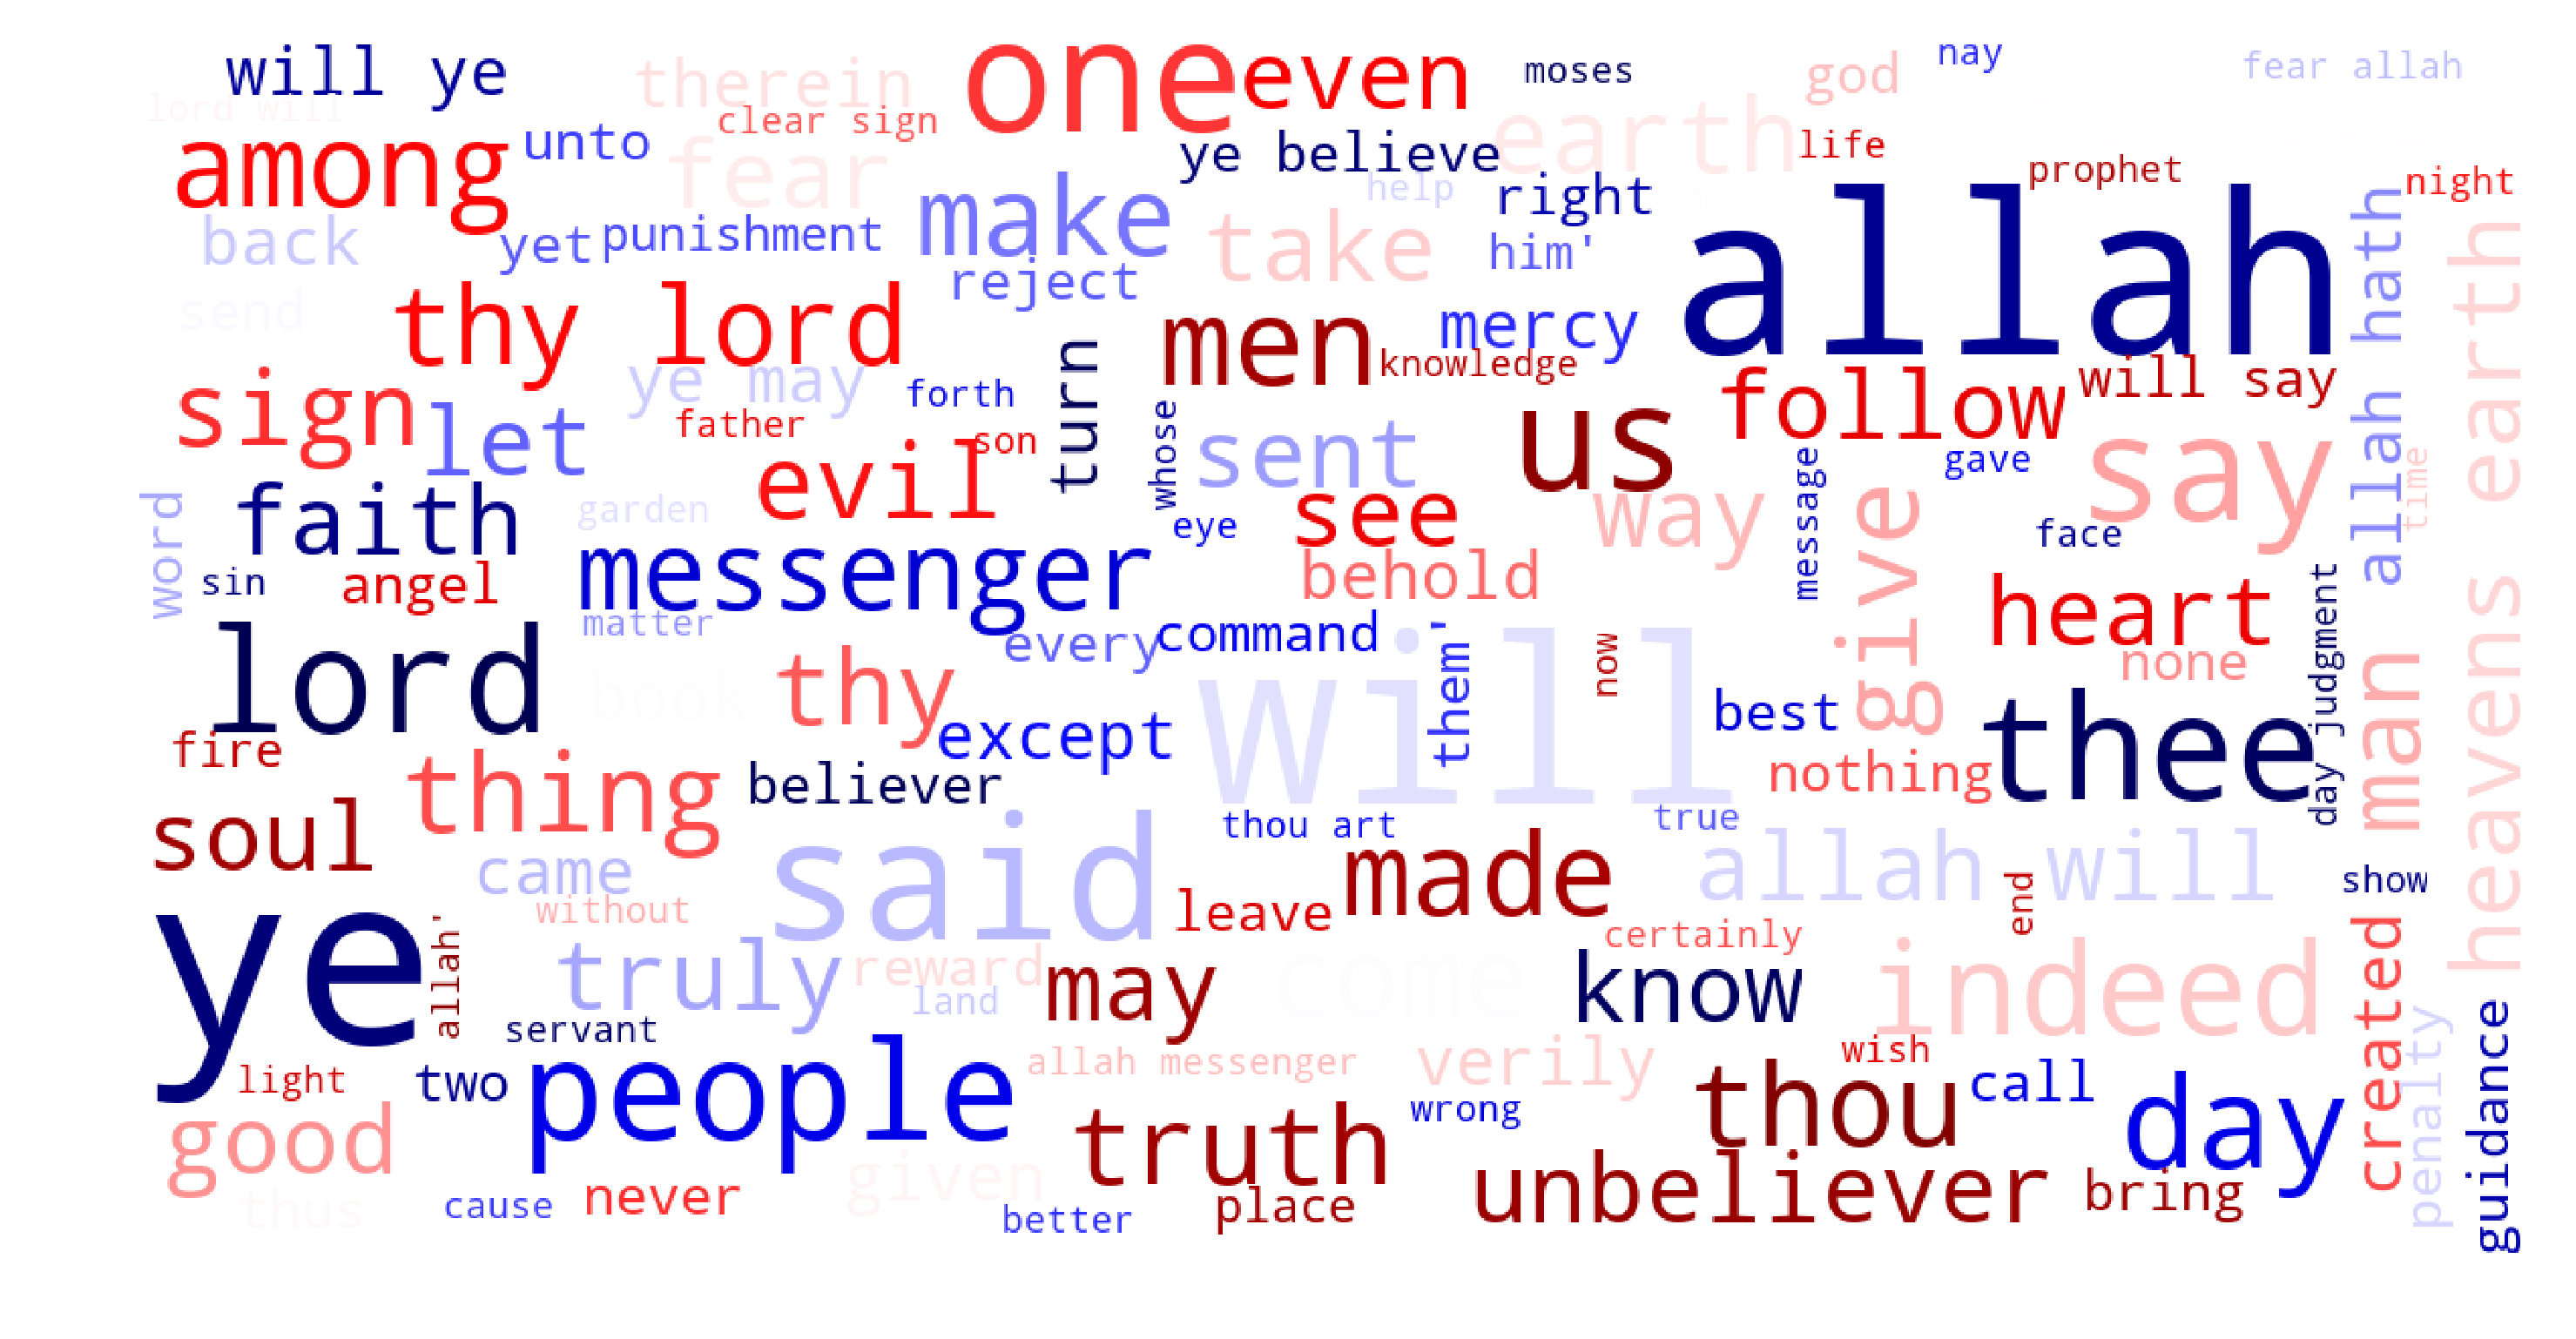

In [68]:
show_wordcloud(clean_quran)

## Model Preparation: Count Vectorization/ tf-idf

In [96]:
def display_topics(model, feature_names, no_top_words):
    topic_list = []
    for topic_idx, topic in enumerate(model.components_):
        topic_list.append(' '.join([feature_names[i] for i in topic.argsort()[:-no_top_words - 1:-1]]))
        print('Topic %d:' % (topic_idx))
        print(topic_list[topic_idx])
    return topic_list

In [285]:
quran_lem_cv = CountVectorizer()
quran_lem_cv_sp_matrix = quran_lem_cv.fit_transform(join_tokenized_words(quran_lemmatized))

quran_lem_cv_df = pd.DataFrame(quran_lem_cv_sp_matrix.toarray(), columns=quran_lem_cv.get_feature_names())

In [286]:
quran_lem_tfidf = TfidfVectorizer()
quran_lem_tfidf_sp_matrix = quran_lem_tfidf.fit_transform(join_tokenized_words(quran_lemmatized))

In [287]:
avg_length = []
for verse in quran_lemmatized:
    avg_length.append(len(verse))

np.array(avg_length).mean()

9.783432332637663

## Topic Modeling
### LSA - Count Vectorizer

In [288]:
lsa = TruncatedSVD(10)
lsa_doc_topic = lsa.fit_transform(quran_lem_cv_sp_matrix)
lsa.explained_variance_ratio_

array([0.01232583, 0.01089445, 0.01013065, 0.00958053, 0.00931052,
       0.00810197, 0.00773501, 0.00719176, 0.00706968, 0.00650588])

In [289]:
sum(lsa.explained_variance_ratio_)

0.08884628931393235

In [290]:
lsa_topic_words = pd.DataFrame(lsa.components_,
             index = [x for x in range(1,11)],
             columns = quran_lem_cv.get_feature_names())

In [291]:
display_topics(lsa, quran_lem_cv.get_feature_names(), 6)

Topic 0:
one people believe day sign
Topic 1:
people messenger sign sent book
Topic 2:
one let evil fear two
Topic 3:
day people one judgment night
Topic 4:
believe men day may messenger
Topic 5:
men people woman may fear
Topic 6:
men sign earth woman one
Topic 7:
messenger hath thing men sent
Topic 8:
men believe earth evil woman
Topic 9:
let believe fear witness thing


['one people believe day sign',
 'people messenger sign sent book',
 'one let evil fear two',
 'day people one judgment night',
 'believe men day may messenger',
 'men people woman may fear',
 'men sign earth woman one',
 'messenger hath thing men sent',
 'men believe earth evil woman',
 'let believe fear witness thing']

### LSA - tf-idf

In [292]:
lsa = TruncatedSVD(10)
lsa_doc_topic = lsa.fit_transform(quran_lem_tfidf_sp_matrix)
lsa.explained_variance_ratio_

array([0.00301784, 0.0059122 , 0.00529976, 0.00505798, 0.00452088,
       0.00442607, 0.0038844 , 0.00377391, 0.00363485, 0.00349978])

In [293]:
sum(lsa.explained_variance_ratio_)

0.04302767454157148

In [294]:
lsa_topic_words = pd.DataFrame(lsa.components_,
             index = [x for x in range(1,11)],
             columns = quran_lem_tfidf.get_feature_names())

In [295]:
display_topics(lsa, quran_lem_tfidf.get_feature_names(), 10)

Topic 0:
believe sign people day one earth
Topic 1:
deny favour day judgment fire recognise
Topic 2:
day earth heaven judgment thing created
Topic 3:
day judgment penalty people fear woe
Topic 4:
believe sign earth reward work deed
Topic 5:
sign people earth heaven day sent
Topic 6:
fear people obey reward earth thing
Topic 7:
one earth people heaven penalty fear
Topic 8:
fear one obey verily merciful believe
Topic 9:
verily sign exalted merciful might made


['believe sign people day one earth',
 'deny favour day judgment fire recognise',
 'day earth heaven judgment thing created',
 'day judgment penalty people fear woe',
 'believe sign earth reward work deed',
 'sign people earth heaven day sent',
 'fear people obey reward earth thing',
 'one earth people heaven penalty fear',
 'fear one obey verily merciful believe',
 'verily sign exalted merciful might made']

### NMF - cv

In [296]:
nmf = NMF(10)
nmf_doc_topic = nmf.fit_transform(quran_lem_cv_sp_matrix)

In [297]:
nmf_topic_words = pd.DataFrame(nmf.components_.round(3),
             index = [x for x in range(1,11)],
             columns = quran_lem_cv.get_feature_names())

In [298]:
topic_list_cv = display_topics(nmf, quran_lem_cv.get_feature_names(), 6)

Topic 0:
believe deed work faith reward good righteousness messenger garden reject
Topic 1:
people book moses god indeed came pharaoh worship among sent
Topic 2:
one evil another two man know god like art brother
Topic 3:
day judgment night penalty fire see life together make truth
Topic 4:
earth heaven created know see power sky belongs praise creation
Topic 5:
men woman give path believer life purity knowledge impure evil
Topic 6:
sign messenger sent come clear book truth unto came reject
Topic 7:
thing hath good power knowledge life unto made knoweth given
Topic 8:
may made give order doth thus know make heart night
Topic 9:
would let fear among witness take heart back indeed two


### NMF - tf-idf

In [299]:
nmf = NMF(10)
nmf_doc_topic = nmf.fit_transform(quran_lem_tfidf_sp_matrix)

In [300]:
nmf_topic_words = pd.DataFrame(nmf.components_.round(3),
             index = [x for x in range(1,11)],
             columns = quran_lem_tfidf.get_feature_names())

In [301]:
topic_list_tfidf = display_topics(nmf, quran_lem_tfidf.get_feature_names(), 10)

Topic 0:
sent messenger truth come book turn men know may among
Topic 1:
deny favour bestowed recognise wont upon child fire israel sinner
Topic 2:
day judgment woe night rejecters truth raised together appointed gather
Topic 3:
earth heaven thing created know power belongs dominion belong hath
Topic 4:
sign believe reject faith verily clear rehearsed work rejected moses
Topic 5:
reward good deed life give garden righteous world work therein
Topic 6:
people fear worship rejected pharaoh moses obey noah brother god
Topic 7:
penalty indeed fire would grievous see taste unbeliever hell evil
Topic 8:
one evil another god art man servant two worship brought
Topic 9:
merciful exalted verily might oftforgiving power full wisdom wise mercy


### LDA - cv

In [302]:
# Convert sparse matrix of counts to a gensim corpus
corpus = matutils.Sparse2Corpus(quran_lem_cv_sp_matrix.transpose())

In [303]:
id2word = dict((v, k) for k, v in quran_lem_cv.vocabulary_.items())

In [304]:
# Create lda model (equivalent to "fit" in sklearn)
lda = models.LdaModel(corpus=corpus, num_topics=10, id2word=id2word, passes=5,random_state=42)

In [305]:
lda.print_topics()

[(0,
  '0.028*"worship" + 0.018*"thing" + 0.012*"one" + 0.011*"hath" + 0.010*"father" + 0.010*"knowledge" + 0.009*"come" + 0.009*"god" + 0.009*"given" + 0.009*"fear"'),
 (1,
  '0.014*"one" + 0.014*"evil" + 0.013*"reject" + 0.013*"among" + 0.013*"truth" + 0.012*"turn" + 0.012*"people" + 0.011*"man" + 0.010*"faith" + 0.010*"believe"'),
 (2,
  '0.031*"day" + 0.019*"away" + 0.019*"explain" + 0.015*"messenger" + 0.014*"child" + 0.014*"favour" + 0.014*"among" + 0.014*"sign" + 0.014*"deny" + 0.013*"turn"'),
 (3,
  '0.028*"fire" + 0.018*"day" + 0.017*"earth" + 0.014*"indeed" + 0.014*"made" + 0.012*"blazing" + 0.012*"make" + 0.009*"path" + 0.008*"certainly" + 0.008*"clamour"'),
 (4,
  '0.023*"man" + 0.023*"garden" + 0.020*"created" + 0.016*"therein" + 0.012*"exalted" + 0.011*"morning" + 0.011*"found" + 0.010*"fire" + 0.010*"river" + 0.010*"ever"'),
 (5,
  '0.018*"witness" + 0.014*"heart" + 0.014*"see" + 0.014*"book" + 0.013*"message" + 0.012*"earth" + 0.011*"make" + 0.011*"sent" + 0.011*"people

### LDA - tf-idf

In [306]:
# Convert sparse matrix of counts to a gensim corpus
corpus = matutils.Sparse2Corpus(quran_lem_tfidf_sp_matrix.transpose())

In [307]:
id2word = dict((v, k) for k, v in quran_lem_tfidf.vocabulary_.items())

In [308]:
# Create lda model (equivalent to "fit" in sklearn)
lda = models.LdaModel(corpus=corpus, num_topics=10, id2word=id2word, passes=5,random_state=42)

In [309]:
lda.print_topics()

[(0,
  '0.017*"worship" + 0.007*"truth" + 0.007*"come" + 0.007*"one" + 0.007*"earth" + 0.007*"heaven" + 0.007*"sent" + 0.006*"people" + 0.006*"thing" + 0.006*"enter"'),
 (1,
  '0.011*"clamour" + 0.010*"high" + 0.010*"day" + 0.010*"know" + 0.009*"soon" + 0.009*"faith" + 0.008*"mount" + 0.008*"dust" + 0.008*"reject" + 0.008*"glorious"'),
 (2,
  '0.017*"noise" + 0.015*"one" + 0.014*"day" + 0.013*"orphan" + 0.011*"steep" + 0.009*"path" + 0.009*"bliss" + 0.008*"knowname" + 0.008*"wellacquainted" + 0.008*"made"'),
 (3,
  '0.010*"judge" + 0.009*"hellfire" + 0.008*"piece" + 0.008*"break" + 0.008*"selfsufficient" + 0.007*"matter" + 0.007*"cry" + 0.006*"day" + 0.006*"road" + 0.006*"mine"'),
 (4,
  '0.013*"created" + 0.012*"woe" + 0.012*"return" + 0.012*"praise" + 0.010*"mischief" + 0.010*"flame" + 0.010*"smooth" + 0.009*"pray" + 0.009*"man" + 0.009*"indeed"'),
 (5,
  '0.012*"man" + 0.012*"fire" + 0.011*"blazing" + 0.010*"see" + 0.010*"cherisher" + 0.009*"doth" + 0.009*"burden" + 0.008*"certainty

### WordtoVec

In [91]:
import gensim
# Load Google's pre-trained Word2Vec model
model = gensim.models.KeyedVectors.load_word2vec_format('/Users/tcbon/Downloads/GoogleNews-vectors-negative300.bin', binary=True)  

In [116]:
# Convert topics to word2vec representation
topic_vectors = []
for topic in topic_list_tfidf:
    row_vector = []
    for w in topic.split():
        try:
            row_vector.append(model.get_vector(w))
        except:
            print(w)
    topic_vectors.append(row_vector)

favour
favour
cherisher
oftforgiving


In [117]:
# Get mean word2vec representation for topics
topic_2_vec = []
for vec_list in topic_vectors:
    vec_sum = np.array(np.zeros((300,)))
    for topic_vec in vec_list:
        vec_sum = vec_sum + topic_vec
    topic_2_vec.append(vec_sum)
    
# goog_model.most_similar_cosmul(positive=preprocess_string(topic_list[0]))[0:3]

In [118]:
topics = []
for i, val in enumerate(topic_2_vec):
    topics.append(model.similar_by_vector(val, topn=5, restrict_vocab=1500))
    print('Topic' + str(i))
    print(topics[i])

Topic0
[('true', 0.5735326409339905), ('not', 0.5526522397994995), ('even', 0.5483345985412598), ('that', 0.5335010290145874), ('do', 0.5318375825881958)]
Topic1
[('know', 0.7512036561965942), ('do', 0.7175317406654358), ('see', 0.6467559337615967), ('tell', 0.6359156370162964), ('want', 0.6340351104736328)]
Topic2
[('love', 0.41500669717788696), ('hope', 0.37374550104141235), ('let', 0.3693855106830597), ('do', 0.35667750239372253), ('even', 0.3385525345802307)]
Topic3
[('love', 0.4575759470462799), ('me', 0.4515238106250763), ('us', 0.43123650550842285), ('do', 0.4301269054412842), ('know', 0.4225170612335205)]
Topic4
[('day', 0.5249146223068237), ('just', 0.4853018820285797), ('one', 0.4527492821216583), ('time', 0.4356380105018616), ('ask', 0.4250366687774658)]
Topic5
[('believe', 0.46045607328414917), ('wrong', 0.4310450255870819), ('that', 0.4263097941875458), ('not', 0.405624657869339), ('simply', 0.39916330575942993)]
Topic6
[('hope', 0.46667569875717163), ('love', 0.4653738141

### PCA/ T-SNE

In [ ]:
pca = PCA(n_components=3)
pca_result = pca.fit_transform()

df['pca-one'] = pca_result[:,0]
df['pca-two'] = pca_result[:,1] 
df['pca-three'] = pca_result[:,2]

print('Explained variation per principal component: {}'.format(pca.explained_variance_ratio_))